### Explore the effect of parasitemia on assay performance

In [24]:
import pandas as pd
import numpy as np
from nomadic.lib.parsing import build_parameter_dict
from nomadic.pipeline.qcbams.plot import MappingStatesAndColors

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.dpi"] = 100

### Define an experiment

In [93]:
class Experiment:
    
    mapping_levels = ["pf_mapped", "hs_mapped", "unmapped"]
    thresh = 100
    focus_columns = ["barcode", 
                     "sample_id", 
                     "parasites_per_ul",
                     "parasites_per_ul_log10",
                     "per_pf_mapped",
                     "per_hs_mapped",
                     "n_reads",
                     "n_reads_log10",
                     "imb_factor",
                     "n_reads_ontarget",
                     "n_targets",
                     f"n_targets_gr{thresh}"
                    ]
    
    def __init__(self, expt_dir):
        """
        Co-ordinate metadata, mapping and balance data for a single
        NOMADS nanopore experiment
        
        """
        # Define directories
        self.expt_dir = expt_dir
        self.nomadic_dir = f"{expt_dir}/nomadic/guppy/hac/single_end/"
        
        # Define paths
        self.metadata_path = f"{expt_dir}/metadata/sample_info.csv"
        self.mapping_path = f"{self.nomadic_dir}/qc-bams/table.mapping.primary_state.csv"
        self.extraction_path = f"{self.nomadic_dir}/target-extraction/table.target_coverage.overview.csv"
        
        
    def _load_metadata(self):
        """ Load metadata """
        
        self.metadata = pd.read_csv(self.metadata_path)
        
        
    def _load_mapping(self):
        """ Load mapping data """
        
        # LOAD
        self.mapping_df = pd.read_csv(self.mapping_path)
        
        # SUMMARY STATISTICS
        # No. reads
        self.mapping_df.insert(4, "n_reads", self.mapping_df[self.mapping_levels].sum(1))
        self.mapping_df.insert(5, "n_reads_log10", np.log10(self.mapping_df["n_reads"] + 1))
        
        # Percentages
        for i, mapping_level in enumerate(self.mapping_levels):
            self.mapping_df.insert(
                6+i,
                f"per_{mapping_level}",
                100*self.mapping_df[mapping_level]/self.mapping_df["n_reads"]
            )
        self.mapping_df.insert(
            self.mapping_df.shape[1], 
            "parasites_per_ul_log10",
            np.log10(self.mapping_df["parasites_per_ul"])
        )
        
        
    def _load_balance(self):
        """ 
        Load balance data 
        
        TODO:
        - Compute median coverage?
        
        """
        
        # LOAD
        self.extraction_df = pd.read_csv(self.extraction_path)
        
        # RESHAPE
        self.balance_df = pd.pivot_table(
            data=expt.extraction_df.query("overlap == 'any'"),
            values="reads_mapped",
            index="sample_id",
            columns="gene_name"
        )
        
        # SUMMARY STATISTICS
        # Ontarget
        n_ontarget = self.balance_df.sum(1)
        
        # Imbalance factor
        min_ontarget = self.balance_df.min(1)
        max_ontarget = self.balance_df.max(1)
        imb_factor = max_ontarget / (min_ontarget + 1)
        
        # Above threshold
        n_targets = self.balance_df.shape[1]
        targets_abv_thresh = self.balance_df.apply(lambda x: (x > self.thresh).sum(), axis=1)
        
        # Store
        self.balance_df.insert(self.balance_df.shape[1], "n_reads_ontarget", n_ontarget)
        self.balance_df.insert(self.balance_df.shape[1], "imb_factor", imb_factor)
        self.balance_df.insert(self.balance_df.shape[1], "n_targets", n_targets)
        self.balance_df.insert(self.balance_df.shape[1], f"n_targets_gr{self.thresh}", targets_abv_thresh)
        
    
    def _merge_dfs(self):
        """ 
        Merge metadata, mapping data, and balance data 
        
        """
        n_barcodes = self.metadata.shape[0]
        assert self.balance_df.shape[0] == n_barcodes
        assert self.mapping_df.shape[0] == n_barcodes
        
        self.merged_df = pd.merge(
            left=self.mapping_df,
            right=self.balance_df,
            on="sample_id",
            how="inner"
        )
        
        assert self.merged_df.shape[0] == n_barcodes
    
    
    def load_data(self):
        """ Load all data and merge """
        
        self._load_metadata()
        self._load_mapping()
        self._load_balance()
        self._merge_dfs()
        
    
    def get_focus_df(self):
        """ Return dataframe with only column of interest """
        
        return self.merged_df[self.focus_columns]

        

### Load and aggregate across experiments

In [125]:
expt_dirs = [
    "../experiments/2021-11-14_strain-validation-flongle-lfb",
    "../experiments/2021-11-20_strain-validation-16plex/",
    "../experiments/2022-03-15_large-lab-validation-r1/"
]
expts = [Experiment(expt_dir) for expt_dir in expt_dirs]

In [135]:
dfs = []
for j, expt_dir in enumerate(expt_dirs):
    expt = Experiment(expt_dir)
    expt.load_data()
    df = expt.get_focus_df()
    df.insert(0, "expt_name", expt_dir)
    df.insert(0, "expt_ix", j)
    dfs.append(df)
final_df = pd.concat(dfs)

/Users/jasongms/opt/anaconda3/envs/nomadic2/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Summarise

In [136]:
final_df.groupby("parasites_per_ul").median()

,expt_ix,parasites_per_ul_log10,per_pf_mapped,per_hs_mapped,n_reads,n_reads_log10,imb_factor,n_reads_ontarget,n_targets,n_targets_gr100
parasites_per_ul,,,,,,,,,,
0,2.0,-inf,77.436809,21.783889,855.5,2.929149,107.000000,595.5,16.0,1.0
10,0.5,1.00000,15.983869,83.855616,9299.0,3.954692,488.357143,1298.0,12.0,2.0
50,2.0,1.69897,28.174461,71.646135,17297.0,4.237996,228.000000,3663.0,16.0,8.0
100,2.0,2.00000,39.190555,60.681806,17489.0,4.242790,254.600000,6597.0,16.0,10.0
250,2.0,2.39794,61.634486,38.046700,22270.0,4.347740,250.875000,12793.0,16.0,12.0
500,2.0,2.69897,68.520508,31.356168,25137.0,4.400331,336.277778,16306.0,16.0,12.0
1000,2.0,3.00000,63.557004,36.349070,22362.0,4.349530,350.062500,10183.0,16.0,11.0
2500,2.0,3.39794,78.481590,21.431014,22752.0,4.357039,314.600000,17480.0,16.0,13.0
5000,2.0,3.69897,84.427926,15.487392,18385.0,4.264487,217.421053,13988.0,16.0,12.0


### Plot

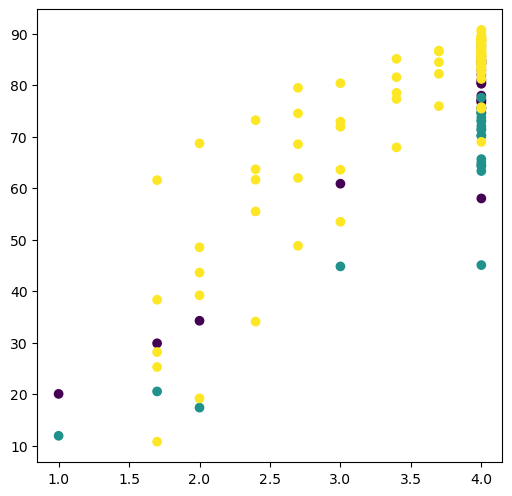

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(x=final_df["parasites_per_ul_log10"],
           y=final_df["per_pf_mapped"],
           c=final_df["expt_ix"])

- Okay, we are starting to get something